<a href="https://colab.research.google.com/github/lallapalooza91/APS360-Final-Project/blob/main/Lab5_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab5_Spam_Detection.ipynb"

[NbConvertApp] Converting notebook /content/Lab5_Spam_Detection.ipynb to html
[NbConvertApp] Writing 757097 bytes to /content/Lab5_Spam_Detection.html


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1lz6NAXXNYZwA0PTqaQ_ZHCFCQLqZqQrm?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

In [ ]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 823.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 65.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0+cu111 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you hav

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
i = 0
for line in open('SMSSpamCollection'):
    split = line.split()
    print('Label: {} | Message: {}'.format(split[0], ' '.join(split[1:])))
    i+=1
    if (i > 5):
      break

Label: ham | Message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Label: ham | Message: Ok lar... Joking wif u oni...
Label: spam | Message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Label: ham | Message: U dun say so early hor... U c already then say...
Label: ham | Message: Nah I don't think he goes to usf, he lives around here though
Label: spam | Message: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


The label value for a spam message is `spam`, and the label value for non-spam message is `ham`.

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam = 0
ham = 0
for line in open('SMSSpamCollection'):
    split = line.split()
    if(split[0] == 'spam'):
      spam+=1
    if(split[0] == 'ham'):
      ham+=1

print('There are {} spam messages in the dataset'.format(spam))
print('There are {} non-spam messages in the dataset'.format(ham))

There are 747 spam messages in the dataset
There are 4827 non-spam messages in the dataset


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:
1. Makes it easier to handle uncommon or misspelt words. The model can still use a word even if it has been misspelt because it is broken down into its individual letters.
2. Language independence. With character modeling, we can model any language once we have the character set (letters) for that language.

Disadvantages:
1. Training time increases. Using character modeling means there are more items in the input sequence and thus takes longer to train.
2. Character-level modelling may not be able to capture the relationships between words, and thus the semantic meaning of the words may be lost. The model may not be able to fully understand the context of the sentence/entire piece of text.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext.legacy.data as data
from torchtext.legacy.data import TabularDataset, Dataset
import csv

In [ ]:
# Define the fields
text_field = data.Field(sequential=True, tokenize= lambda x:list(x), batch_first=True)
# I converted 'spam' to 1 and 'ham' to 0
label = data.Field(sequential=False, preprocessing=lambda x: int(x == 'spam'), use_vocab=False)

# Load the dataset
all_data = data.TabularDataset(
    path='/content/SMSSpamCollection', format='tsv', fields=[('label', label), ('text', text_field)],
    skip_header=False
)

In [ ]:
# splitting the data
train_data, val_data = Dataset.split(
    all_data,
    split_ratio=0.6,  # 60% for training
    stratified=True,
    strata_field='label'
)

In [ ]:
val_data, test_data = Dataset.split(
    val_data,
    split_ratio=0.5,  # 20% each for val and test
    stratified=True,
    strata_field='label'
)

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

A balanced training set is helpful because if there is an imbalance, the model may only learn to predict the majority class (the class with more samples) correctly and ignore the minority classes. In this case, it may predict all messages as non-spam messages. This is important in this case because we are more interested in identifying which messages are spam (minority) than non-spam (majority).

If the model is trained on an imbalanced training set it may not generalize well to new data, especially examples from the minority classes.

Finally, having a balanced training set improves performance of the model as it is now forced to learn more about the minority classes and thus make better predictions.

In [ ]:
# save the original training examples
old_train_examples = train_data.examples
# get all the spam messages in `train`
train_spam = []
for item in train_data.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_data.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train_data)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fbfbd62b9d0>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, 'f': 23, '1': 24, 'b': 25, '2': 26, '8': 27, 'T': 28, 'k': 29, 'v': 30, 'E': 31, 'S': 32, '5': 33, 'C': 34, 'O': 35, 'I': 36, '4': 37, '7': 38, 'N': 39, 'A': 40, 'x': 41, '3': 42, '6': 43, 'R': 44, ',': 45, '9': 46, '!': 47, 'P': 48, 'U': 49, 'M': 50, 'W': 51, 'H': 52, 'L': 53, 'D': 54, 'B': 55, 'F': 56, 'Y': 57, 'G': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'V': 66, 'z': 67, 'X': 68, 'K': 69, 'j': 70, ')': 71, 'J': 72, '*': 73, '+': 74, ';': 75, '(': 76, '"': 77, 'q': 78, 'Q': 79, '#': 80, '=': 81, '@': 82, 'Z': 83, '>': 84, 'ü': 85, '$': 86, 'Ü': 87, '<': 88, '\x92': 89, '‘': 90, '|': 91, '[': 92, ']': 93, '_': 94, '\x93': 95, '¡': 96, '%': 97, '’': 98,

build_vocab is a function in PyTorch's torchtext library that is used to create the vocabulary for text data. It takes a dataset as input and returns a vocabulary object that can be used to map words to unique integer IDs.

`text_field.vocab.stoi` is a dictionary that maps each unique character from the vocabulary created by `build_vocab` (obtained from all the messages in the training data in this case) to a corresponding index.

`text_field.vocab.itos` is a list of all the unique characters in the messages, organized by their index from `text_field.vocab.stoi`.


### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` stands for "unknown" and `<pad>` stands for "padding".

`<unk>` is assigned to any letter that is not present in the vocabulary, that may appear in testing/inference.

`<pad>` is used to pad the character sequences (or sentences) to a fixed length. All sentences in a batch are padded with this token at the end if necessary so that they all have the same length to pass to the network.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = data.BucketIterator(train_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i = 0
for batch in train_iter:
    i+=1
    pad_count = 0
    max_length = len(batch.text[0])
    print("Batch {}:".format(i))
    print('Maximum length of input sequence: {}'.format(max_length))
    for j in range(0,len(batch.text)):
      # count the pad tokens in each tensor
      pad_count += (batch.text[j] == 1).sum().item()
    print('Number of pad tokens: {}\n'.format(pad_count))
    # look at 10 batches
    if (i>9):
      break

Batch 1:
Maximum length of input sequence: 148
Number of pad tokens: 24

Batch 2:
Maximum length of input sequence: 45
Number of pad tokens: 12

Batch 3:
Maximum length of input sequence: 36
Number of pad tokens: 32

Batch 4:
Maximum length of input sequence: 126
Number of pad tokens: 13

Batch 5:
Maximum length of input sequence: 171
Number of pad tokens: 158

Batch 6:
Maximum length of input sequence: 96
Number of pad tokens: 61

Batch 7:
Maximum length of input sequence: 56
Number of pad tokens: 38

Batch 8:
Maximum length of input sequence: 149
Number of pad tokens: 0

Batch 9:
Maximum length of input sequence: 59
Number of pad tokens: 51

Batch 10:
Maximum length of input sequence: 44
Number of pad tokens: 38



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.name = 'rnn'
        # construct matrix for onehot encodings
        # its length must be the number of all possible characters
        self.ident = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Get onehot encoding of input
        x = self.ident[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
# this function is used to save checkpoints
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
import matplotlib.pyplot as plt

def train_rnn_network(model, train, valid, batch_size = 32, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # getting the data
    train_iter = data.BucketIterator(train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    val_iter = data.BucketIterator(valid,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


    train_losses, val_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        # train loss
        for batch in train_iter:
            optimizer.zero_grad()
            pred = model(batch.text)
            train_loss = criterion(pred, batch.label)
            train_loss.backward()
            optimizer.step()

        # validation loss
        for batch in val_iter:
            optimizer.zero_grad()
            pred = model(batch.text)
            val_loss = criterion(pred, batch.label)

        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_iter))
        valid_acc.append(get_accuracy(model, val_iter))

        print("Epoch {}; Train Loss {}; Train Acc {}; Val Loss {}; Val Acc {}".format(
              epoch+1, train_losses[-1], train_acc[-1], val_losses[-1], valid_acc[-1]))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def get_accuracy(model, data_iter):
    correct, total = 0, 0
    for batch in data_iter:
        output = model(batch.text)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.label.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

Here is the training curve of my final model. It was obtained using Hyperparameter Set 4 which is described in Part (c). I chose this model as the best because it gave me the highest validation accuracy of `0.979`.

Epoch 1; Train Loss 0.7435335516929626; Train Acc 0.5297628917260819; Val Loss 0.673870861530304; Val Acc 0.15426008968609867
Epoch 2; Train Loss 0.385085791349411; Train Acc 0.8322002984579672; Val Loss 0.6867537498474121; Val Acc 0.6887892376681615
Epoch 3; Train Loss 0.4578331708908081; Train Acc 0.8962029514176754; Val Loss 0.3786284029483795; Val Acc 0.9461883408071748
Epoch 4; Train Loss 0.2727833390235901; Train Acc 0.9384844967667053; Val Loss 0.44817766547203064; Val Acc 0.9219730941704036
Epoch 5; Train Loss 0.18146400153636932; Train Acc 0.9291991377880948; Val Loss 0.2517603635787964; Val Acc 0.9533632286995516
Epoch 6; Train Loss 0.05240238457918167; Train Acc 0.9532415851434256; Val Loss 0.37246936559677124; Val Acc 0.9363228699551569
Epoch 7; Train Loss 0.12309063225984573; Train Acc 0.9527441551981429; Val Loss 0.14449335634708405; Val Acc 0.9533632286995516
Epoch 8; Train Loss 0.14242567121982574; Train Acc 0.9540706350522301; Val Loss 0.20391632616519928; Val Acc 0.93

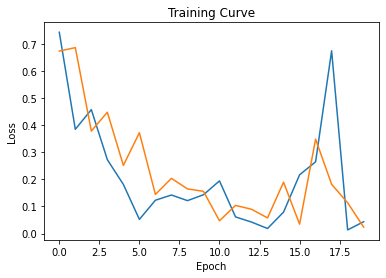

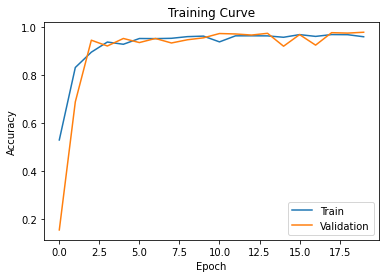

In [ ]:
model = RNN_hidden(100, 2)
train_rnn_network(model, train_data, val_data, batch_size = 32, num_epochs=20, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

**Hyperparameter Set 1**

For the first hyperparameter set I changed the model architecture. I used
```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```
at the output of the RNN.

I used a batch size of 32, and a learning rate of `1e-4`. This gave good results as I obtained a validation accuracy as high as `0.96`. However, to do better, I will try max-pooling over the output array.

In [ ]:
model = RNN(50, 2)

train_rnn_network(model, train_data, val_data, batch_size = 32, num_epochs=20, learning_rate=1e-4)

**Hyperparameter Set 2**



For this hyperparameter set I changed the model architecture. I used
```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```
at the output of the RNN.

This gave me better results than hyperparameter set 1 as I obtained a validation accuracy as high as `0.973`. However, to see if I can do better I will try concatenating the
max-pooling and average-pooling of the RNN outputs.



In [ ]:
class RNN_pool(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(RNN_pool, self).__init__()
        self.name = 'rnn_pool'
        # construct matrix for onehot encodings
        # its length must be the number of all possible characters
        self.ident = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Get onehot encoding of input
        x = self.ident[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        out, _ = self.rnn(x)
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [ ]:
model = RNN_pool(50, 2)
train_rnn_network(model, train_data, val_data, batch_size = 32, num_epochs=20, learning_rate=1e-4)

**Hyperparameter Set 3**



For this hyperparameter set I changed the model architecture. I used
```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```
at the output of the RNN.

This gave me the best results so far as I obtained a final validation accuracy of `0.978`.

In [ ]:
class RNN_concat(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(RNN_concat, self).__init__()
        self.name = 'rnn_concat'
        # construct matrix for onehot encodings
        # its length must be the number of all possible characters
        self.ident = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # Get onehot encoding of input
        x = self.ident[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

In [ ]:
model = RNN_concat(50, 2)
train_rnn_network(model, train_data, val_data, batch_size = 32, num_epochs=20, learning_rate=1e-4)

**Hyperparameter Set 4**

For this hyperparameter set I changed the model architecture to see if I can somehow improve. I increased `hidden_size` to 100.
This did improve the validation accuracy as its final value is now `0.979`. Thus, I will choose this as my best model.

It should be noted that I used the concatenated RNN architecture here as well.



In [ ]:
class RNN_hidden(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(RNN_hidden, self).__init__()
        self.name = 'rnn_hidden'
        # construct matrix for onehot encodings
        # its length must be the number of all possible characters
        self.ident = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # Get onehot encoding of input
        x = self.ident[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

In [ ]:
model = RNN_hidden(100, 2)
train_rnn_network(model, train_data, val_data, batch_size = 32, num_epochs=20, learning_rate=1e-4)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# using model from hyperparameter set 4
model_path = get_model_name('rnn_hidden', batch_size=32, learning_rate=1e-4, epoch=19)
state = torch.load(model_path)
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = data.Dataset(
    [e for e in val_data.examples if e.label == 1],
    val_data.fields)

val_spam_iter = data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
valid_nospam = data.Dataset(
    [e for e in val_data.examples if e.label == 0],
    val_data.fields)

val_nospam_iter = data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# number of false positives is the number of non-spam identified as spam
# check for
false_positive_rate = 1 - get_accuracy(model, val_nospam_iter)
print('False positive rate across validation set: {} %'.format(false_positive_rate*100))

# false negatives are spam identified as non-spam
false_negative_rate = 1 - get_accuracy(model, val_spam_iter)
print('False negative rate across validation set: {} %'.format(false_negative_rate*100))

False positive rate across validation set: 1.0362694300518172 %
False negative rate across validation set: 7.9999999999999964 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A false positive would mean that one of the user's non-spam messages, for example a message from a friend, would be identified as spam and probably deleted. This impact is not so bad as the friend would probably send another text or call the user. No harm comes to the user.

A false negative would mean that a spam message would be identified as non-spam and thus may lead to the user being scammed/phished or harmed in some way. This has a big impact as the user is being harmed.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
# getting test data
test_iter = data.BucketIterator(test_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# using model from hyperparameter set 4
model_path = get_model_name('rnn_hidden', batch_size=32, learning_rate=1e-4, epoch=19)
state = torch.load(model_path)
model.load_state_dict(state)

test_acc = get_accuracy(model, test_iter)
print('Final test accuracy: {}'.format(test_acc))

Final test accuracy: 0.9784560143626571


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = data.Dataset(
    [e for e in test_data.examples if e.label == 1],
    test_data.fields)

test_spam_iter = data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
test_nospam = data.Dataset(
    [e for e in test_data.examples if e.label == 0],
    test_data.fields)

test_nospam_iter = data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.text), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# number of false positives is the number of non-spam identified as spam
# check for
false_positive_rate = 1 - get_accuracy(model, test_nospam_iter)
print('False positive rate across test set: {} %'.format(false_positive_rate*100))

# false negatives are spam identified as non-spam
false_negative_rate = 1 - get_accuracy(model, test_spam_iter)
print('False negative rate across test set: {} %'.format(false_negative_rate*100))

False positive rate across test set: 1.3471502590673534 %
False negative rate across test set: 8.7248322147651 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

# using model from hyperparameter set 4
model_path = get_model_name('rnn_hidden', batch_size=32, learning_rate=1e-4, epoch=19)
state = torch.load(model_path)
model.load_state_dict(state)

# looking up the index of each character
# vector to store the indices
indices = []
for letter in msg:
  indices.append(text_field.vocab.stoi[letter])

# converting to a tensor to pass to model
indices_tensor = torch.tensor(indices)

# adding a dimension to be compatible with model and obtaining prediction
prediction = model(indices_tensor.unsqueeze(0))

# obtaining the probabilities using softmax
probability = F.softmax(prediction, dim=1)

# obtaining the prediction of the probability of a spam message
print('The model predicts the message is spam with a probability of {} %'.format(probability[0][1]*100))

The model predicts the message is spam with a probability of 2.8052587509155273 %


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam can sometimes be a difficult task. Some scammers have become very skilled and it sometimes hard to know if a message or email is spam or not.

**Baseline model**

You can use a rules-based algorithm for the baseline model.

You can associate certain words/phrases with spam messages, such as "Free money" or "Congrats you won $1000". So once a message contains these words or phrases, the algorithm will automatically classify it as spam.

First build a list of words/phrases (from your knowledge/internet) that, once included in a message, will identify the message as spam.

The algorithm can first parse the message, looking for these key words/phrases.

If the message includes such words/phrases, identify it as spam.